# TensorFlex
## Challenge 2 - Time Series Forecasting
Sironi Alessandro, Stefanizzi Giovanni, Stefanizzi Tomaso, Villa Ismaele

In [1]:
# Fix randomness and hide warnings
seed = 69420

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import libraries
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Layer

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.13.0


In [3]:
# Load data
categories_path = '../data/categories.npy'
dataset_path = '../data/training_data.npy'
valid_path = '../data/valid_periods.npy'
categories = np.load(categories_path, allow_pickle=True)
dataset = np.load(dataset_path, allow_pickle=True)
valid = np.load(valid_path, allow_pickle=True)
print('Data loaded')

Data loaded


In [4]:
valid_df = pd.DataFrame(valid) # Convert to pandas dataframe
valid_df.head() # Show first 5 rows

,0,1
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776


In [5]:
df = pd.DataFrame(dataset).T # Transpose to get correct dimensions
df.head()

,0,1,2,3,4,5,6,7,8,9,...,47990,47991,47992,47993,47994,47995,47996,47997,47998,47999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Convert the numbers in the new_df to np.float32
df = df.astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Columns: 48000 entries, 0 to 47999
dtypes: float32(48000)
memory usage: 508.3 MB


In [7]:
test_size = 100 
X_train_raw = df.iloc[:,:-test_size] # Select all but the last 100 columns
X_test_raw = df.iloc[:,-test_size:] # Select the last 100 columns
print(X_train_raw.shape, X_test_raw.shape) # Print the shapes of the train and test sets

(2776, 47900) (2776, 100)


In [8]:
# Set the window, the stride and the telescope
window = 200
stride = 10
telescope = 18

In [10]:
"""
Builds sequences from a given dataframe.

Args:
    df (pandas.DataFrame): The input dataframe.
    target_labels (list): The target labels to be predicted.
    window (int): The length of each sequence.
    stride (int): The stride between consecutive sequences.
    telescope (int): The length of the predicted sequence.

Returns:
    tuple: A tuple containing the dataset and labels arrays.
"""
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    target = df.columns
    temp_df = df.copy().values
    temp_label = df[target].copy().values

    for i in range(len(df.columns)):
        series_len = valid[i][1] - test_size - valid [i][0] 
        padding_check = series_len%window # Check if padding is needed
        if(padding_check != 0): # If padding is needed
            padding_len = window - padding_check # Calculate the padding length
            valid[i][0] = (valid[i][0] - padding_len + window) if valid[i][0] - padding_len < 0 else valid[i][0] - padding_len # Update the start index
        for idx in np.arange(valid[i][0], len(temp_df)-window-telescope, stride): # Iterate over the dataframe
            dataset.append(temp_df[idx:idx+window, i]) # Append the sequence to the dataset 
            labels.append(temp_df[idx+window:idx+window+telescope, i]) # Append the label to the labels array

    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [11]:
target_labels = df.columns
target_labels

RangeIndex(start=0, stop=48000, step=1)

In [12]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope) # Build the training sequences
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope) # Build the test sequences
X_train.shape, y_train.shape, X_test.shape, y_test.shape # Print the shapes of the train and test sets

((456527, 200), (456527, 18), (2644, 200), (2644, 18))

In [13]:
X_train # Print the training sequences

array([[0.        , 0.        , 0.        , ..., 0.18333334, 0.1388889 ,
        0.16111112],
       [0.        , 0.        , 0.        , ..., 0.28611112, 0.2574074 ,
        0.21574074],
       [0.        , 0.        , 0.        , ..., 0.28425926, 0.30925927,
        0.31944445],
       ...,
       [0.8802951 , 0.87125176, 0.8605426 , ..., 0.39505   , 0.39623988,
        0.41361257],
       [0.81128037, 0.802951  , 0.7946216 , ..., 0.447406  , 0.44312233,
        0.44121847],
       [0.750595  , 0.74535936, 0.73346025, ..., 0.41789624, 0.42170396,
        0.41408852]], dtype=float32)

In [14]:
# Custom Attention Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        query, key, value = inputs
        attn_scores = tf.matmul(query, key, transpose_b=True) # Calculate the attention scores 
        attn_scores = tf.nn.softmax(attn_scores, axis=-1) # Apply softmax to the attention scores 
        output = tf.matmul(attn_scores, value) # Calculate the weighted sum of the values
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [15]:
batch_size = 128
epochs = 200

In [16]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    # Add a Bidirectional LSTM layer with 128 units
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    # Attention mechanism
    attention = AttentionLayer(name='attention')([lstm, lstm, lstm])
    # Concatenate attention output with LSTM output
    combined = tfkl.Concatenate(axis=-1)([lstm, attention])

    # Add a 1D Convolution layer with 256 filters and a kernel size of 3
    x = tfkl.Conv1D(256, 3, padding='same', activation='relu', name='conv1')(combined)
    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)
    # Calculate the size to crop from the output to match the output shape
    crop_size = 200-telescope
    # Crop the output to the desired length
    x = tfkl.Cropping1D((0, crop_size), name='cropping')(x)
    # Flatten the output
    output_layer=tfkl.Flatten()(x) 

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [17]:
X_train = np.expand_dims(X_train, axis = -1) # Add a dimension to the array

input_shape = X_train.shape[1:]  
output_shape = y_train.shape[1:]

input_shape, output_shape

((200, 1), (18,))

In [19]:
model = build_CONV_LSTM_model(input_shape, output_shape) # Build the model
model.summary() # Print the model summary
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True) # Plot the model

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 attention (AttentionLayer)  (None, 200, 256)             0         ['bidirectional_lstm[0][0]',  
                                                                     'bidirectional_lstm[0][0]',  
                                                                     'bidirectional_

In [22]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True), # Stop training when the validation loss stops decreasing
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-4) # Reduce the learning rate when the validation loss stops decreasing
    ]
).history

Epoch 1/200
3210/3210 [==============================] - 116s 35ms/step - loss: 0.0219 - val_loss: 0.0196 - lr: 0.0010
Epoch 2/200
3210/3210 [==============================] - 108s 34ms/step - loss: 0.0145 - val_loss: 0.0183 - lr: 0.0010
Epoch 3/200
3210/3210 [==============================] - 109s 34ms/step - loss: 0.0136 - val_loss: 0.0174 - lr: 0.0010
Epoch 4/200
3210/3210 [==============================] - 110s 34ms/step - loss: 0.0130 - val_loss: 0.0171 - lr: 0.0010
Epoch 5/200
3210/3210 [==============================] - 111s 34ms/step - loss: 0.0125 - val_loss: 0.0165 - lr: 0.0010
Epoch 6/200
3210/3210 [==============================] - 111s 35ms/step - loss: 0.0120 - val_loss: 0.0160 - lr: 0.0010
Epoch 7/200
3210/3210 [==============================] - 109s 34ms/step - loss: 0.0117 - val_loss: 0.0157 - lr: 0.0010
Epoch 8/200
3210/3210 [==============================] - 110s 34ms/step - loss: 0.0115 - val_loss: 0.0155 - lr: 0.0010
Epoch 9/200
3210/3210 [=========================

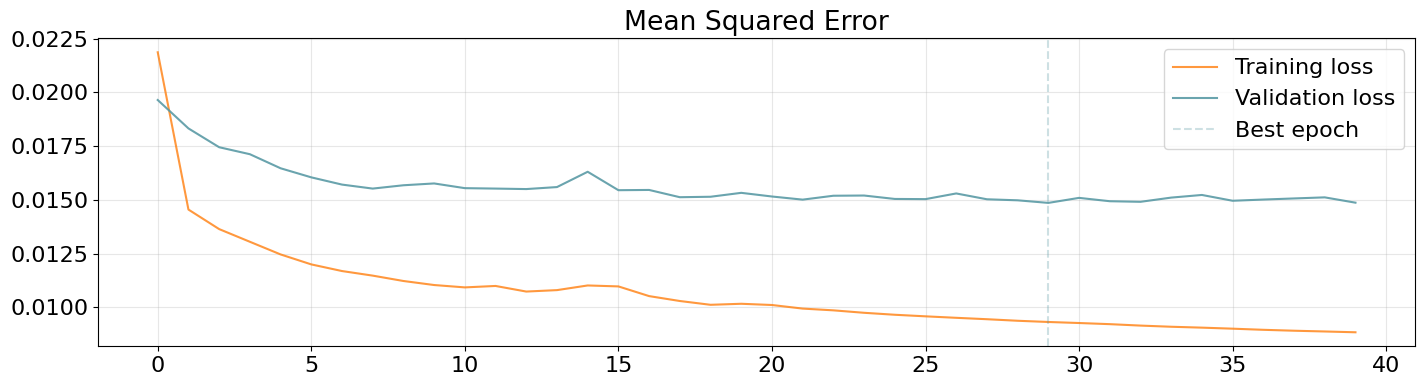

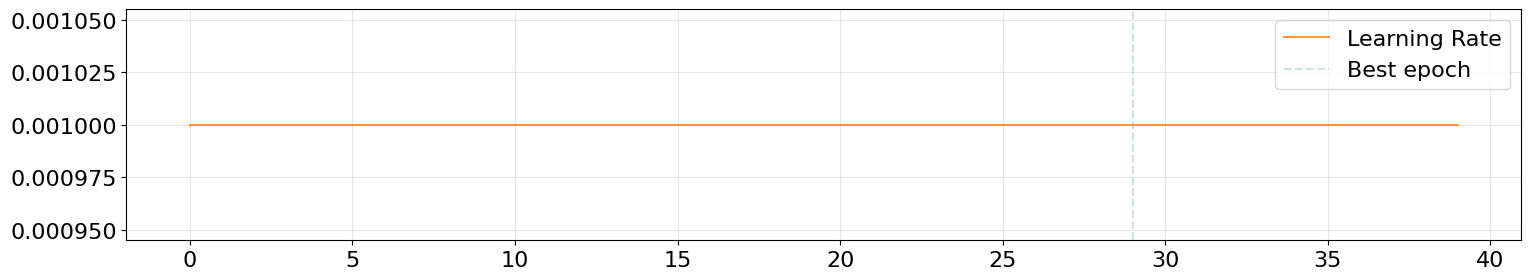

In [23]:
# Plot the training history

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
modelName = "TensorFlex"
model.save(modelName)
model = tfk.models.load_model(modelName)

In [25]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (2644, 18)
Mean Squared Error: 0.007878106087446213
Mean Absolute Error: 0.0450182743370533
